In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1

### Load Dataset

In [3]:
#Load Dataset
floor = FloorPlanDataset(subset='../data/res_index.xlsx', multi_scale=False, preprocess=True)
data_variance = floor.var

val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])
data_variance = get_data_variance(train_set)

print(f"data shape: {floor[0].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([1, 56, 56]), dataset size: 2138, data variance: 0.0068568019196391106


In [4]:
floor.all_data_dirs.__len__()

2138

### Load Best or Train

In [5]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [6]:
vqvae.load_state_dict(torch.load("../checkpoint/vqae_residential/200-vqae-0.12810542326018284.pt"))
# optimizer.load_state_dict(torch.load("checkpoint/95-adam-0.21704871313912527.pt"))

with open("../checkpoint/vqae_residential/200-vqae_train-0.12810542326018284.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../checkpoint/vqae_residential/200-vqae_test-0.12810542326018284.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 200
end_epoch = 250
best_loss = 0.2

##### train

In [7]:
for epoch in range(start_epoch, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.63batch/s, loss=0.368]


Validation Loss: 0.4400634049249927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.307]


Validation Loss: 0.27835312247835975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.04batch/s, loss=0.333]


Validation Loss: 0.2618121026267468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.11batch/s, loss=0.321]


Validation Loss: 0.27432185607337056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.02batch/s, loss=0.311]


Validation Loss: 0.2777444812613474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31batch/s, loss=0.188]


Validation Loss: 0.20345518622599856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.11batch/s, loss=0.208]


Validation Loss: 0.19272015352204372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.271]


Validation Loss: 0.18531792152655518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.217]


Validation Loss: 0.17534741325557512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.179]


Validation Loss: 0.16794750500173078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.21]


Validation Loss: 0.15089869163405728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.54batch/s, loss=0.167]


Validation Loss: 0.15297822549309528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.255]


Validation Loss: 0.15054604704950897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.95batch/s, loss=0.174]


Validation Loss: 0.13889290805154003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.07batch/s, loss=0.169]


Validation Loss: 0.14094616437741847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.195]


Validation Loss: 0.1347357432047526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.06batch/s, loss=0.169]


Validation Loss: 0.15755867398400822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.187]


Validation Loss: 0.154734687626082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.20batch/s, loss=0.171]


Validation Loss: 0.17440978126346784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.01batch/s, loss=0.221]


Validation Loss: 0.12556864510119803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=0.156]


Validation Loss: 0.13166468356136984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.16batch/s, loss=0.763]


Validation Loss: 0.13249427276038228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.194]


Validation Loss: 0.1476199593342526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.138]


Validation Loss: 0.12518366513677606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21batch/s, loss=0.161]


Validation Loss: 0.11686583416003016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.14]


Validation Loss: 0.11857927796986181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.30batch/s, loss=0.141]


Validation Loss: 0.11468602570009903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.138]


Validation Loss: 0.10837328825758097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.26batch/s, loss=0.183]


Validation Loss: 0.11447602034734448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s, loss=0.178]


Validation Loss: 0.11253488119779058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.14]


Validation Loss: 0.10612862098944578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.28batch/s, loss=0.101]


Validation Loss: 0.10730700873433144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.119]


Validation Loss: 0.1037481558714674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.11batch/s, loss=0.123]


Validation Loss: 0.10144981420096097


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.09batch/s, loss=0.126]


Validation Loss: 0.09900687669924169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.129]


Validation Loss: 0.10427414083704703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.16batch/s, loss=0.11]


Validation Loss: 0.0978929448015813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.06batch/s, loss=0.135]


Validation Loss: 0.10098210634759894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.136]


Validation Loss: 0.09886770293186528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.167]


Validation Loss: 0.10201300589691305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.00batch/s, loss=0.149]


Validation Loss: 0.2095193280860292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.73batch/s, loss=0.213]


Validation Loss: 0.1015969218222748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.38batch/s, loss=0.122]


Validation Loss: 0.0961189135699205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.147]


Validation Loss: 0.10251384609741784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.551]


Validation Loss: 0.1299008203784065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.0969]


Validation Loss: 0.11742126661846894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.138]


Validation Loss: 0.10867027497627366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.0941]


Validation Loss: 0.09226378588609292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.107]


Validation Loss: 0.08777431255215211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.102]


Validation Loss: 0.08655555931055489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.90batch/s, loss=0.126]


Validation Loss: 0.09231069054402097


### Visualization

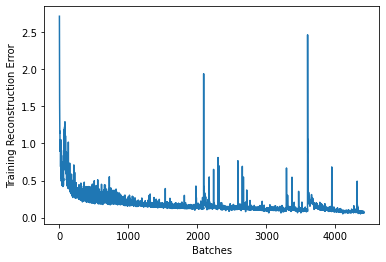

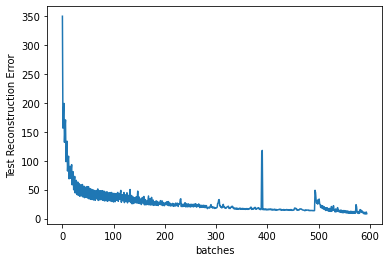

In [8]:
plt.plot(train_res_recon_error[5:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[5:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

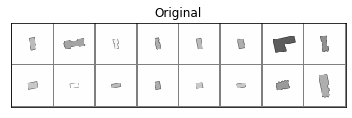

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


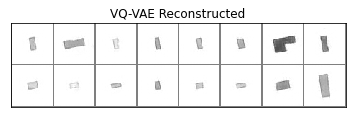

In [9]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()